#### Kelly Connell
Student Number: 22264833

### A. Import Python Modules and Dataset

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold
from sklearn import cluster 
from sklearn import preprocessing 

In [206]:
df = pd.read_csv("loans_train_prepared-1.csv")
data = np.array(df.values, dtype=float) 

print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


### B. Rescale the Data

In [207]:
#data looks scaled already? 
df.describe().transpose().style.format("{:.2f}")

### C. Scatterplot Function 

In [208]:
#function is straight from lab3 
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])  #removed blue duplicate

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

### D. K-Means Clustering

#### D1. Find Optimal K

My initial instinct for K was 2 clusters, following the EDA on the dataset in lab1, we know that this data focus's on loan status Y/N, so I think our data should have 2 relatively clear clusters. Let's see if this is the case with elbow/shilouette techniques

In [209]:
#elbow method, KMeans

kRange = range(1,21)      #try K from 1 -> 20 clusters                       
elbowErr = []

#cycle through kmeans for values of k from 2 - 20, recording the error (inertia is Sum of Squared error) at each value of K 
for k in kRange:
    elbow = cluster.KMeans(n_clusters = k, n_init=10, max_iter=300)
    elbow.fit(df)
    elbowErr.append(elbow.inertia_)

#https://www.youtube.com/watch?v=EItlUEPCIzM
#https://github.com/codebasics/py/blob/master/ML/13_kmeans/13_kmeans_tutorial.ipynb

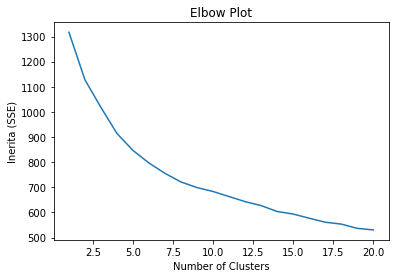

In [210]:
#elbow plot

plt.xlabel('Number of Clusters')
plt.ylabel('Inerita (SSE)')
plt.title('Elbow Plot')
plt.plot(kRange, elbowErr);

More of a floppy noodle than an elbow, with no distinguishable optimal value for K. 

Let's try the silhouette method:

In [211]:
#silhouette method, KMeans
from sklearn.metrics import silhouette_score

silScore=[]
kSil = range(2,21)               #range 2-20 (silhouette can't work with only 1 cluster, as the score is the rank between different cluster sizes

for k in kSil:
    sil = cluster.KMeans(n_clusters = k, n_init=10, max_iter=300)
    sil.fit(df)
    silScore.append(silhouette_score(df, sil.labels_))

#https://www.youtube.com/watch?v=i35RO37vVN4

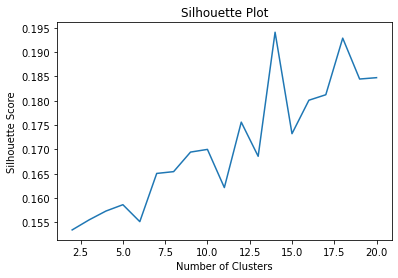

In [212]:
#silhouette plot

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Plot')
plt.plot(kSil, silScore);

The highest silhouette score should be the optimal number of clusters, this plot is indicating that from 2-20, 20 is our best value of K, and when I try a larger range this increases further. But we want to find the lowest number of clusters that gives us the best error balance, so I'm going to rule out 20. 

I'm not really sure, but it feels like our dataset has too much features/attributes, I'm going to strip the data set back to the 3 sets of variables had the highest correlations with Loan Status from our EDA: Loan Amount, Applicant Income and Credit History. Then retest the elbow and silhouette plots. It does feel like I'm chasing after my initial assumption of k=2, I would make for a very biased detective, but previous analysis hasn't worked, so lets give this a shot. 

In [213]:
dfNew = pd.concat([df['LoanAmount'],df['ApplicantIncome'],df['Credit_History'], df['Loan_Status_Y']], axis=1)
dfNew

LoanAmount  ApplicantIncome  Credit_History  Loan_Status_Y
0      1.058140         1.084523               1              1
1      1.047319         0.925883               1              0
2      0.635920         0.683858               1              1
3      1.002824         0.608992               1              1
4      1.115650         1.101869               1              1
..          ...              ...             ...            ...
609    0.676143         0.666409               1              1
610    0.395858         0.858916               1              1
611    1.566110         1.313719               1              1
612    1.325676         1.267616               1              1
613    1.074155         0.925883               0              0

[614 rows x 4 columns]

In [214]:
#New elbow test

newElbowError = []

for k in kRange:
    newElbow = cluster.KMeans(n_clusters = k, n_init=10, max_iter=300)
    newElbow.fit(dfNew)
    newElbowError.append(newElbow.inertia_)

In [215]:
#New elbow plot

plt.xlabel('Number of Clusters')
plt.ylabel('Inerita (SSE)')
plt.title('New Dataset Elbow Plot')
plt.plot(kRange, newElbowError);

My arm is growing some bones, let's check the silhouette:

In [216]:
#New silhouette test

newSilScore=[]

for k in kSil:
    newSil = cluster.KMeans(n_clusters = k, n_init=10, max_iter=300)
    newSil.fit(dfNew)
    newSilScore.append(silhouette_score(dfNew, newSil.labels_))

In [217]:
#New silhouette plot

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('New Silhouette Plot')
plt.plot(kSil, newSilScore);

Bingpot! A very clear k=4 winner! My conscious is clearer that it didn't turn out to be 2, but I'm still not fully sure if my approach to strip the data-set was correct, but for the sake of performing the clustering techniques, I will use k=4

In [218]:
k = 4

I should have done PCA...

#### D2. Perform KMeans clustering with k=4

I'm not sure whether to proceed with df or dfNew, based on my clusters from above

In [219]:
#Kmeans, with k=4 on the original data-set
kMeans4 = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(df)
kMeans4Centers = np.r_[df,kMeans4.cluster_centers_]                               #finds the center of the clusters and adds it to the dataset
kMeansXYcoordinates = manifold.MDS(n_components=2).fit_transform(kMeans4Centers)  #scales our data to 2D (n_components = 2) using Multi-Dimensional Scaling

clustering_scatterplot(points = kMeansXYcoordinates[:-k,:], labels = kMeans4.labels_, centers = kMeansXYcoordinates[-k:,:], title='KMeans Clustering, Multi-Dimensional Scaling, 15-Features')

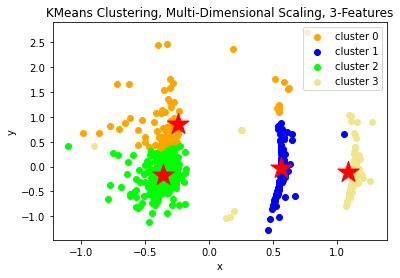

In [220]:
#Kmeans, with k=4 on the new data-set
kMeans4New = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(dfNew)
kMeans4NewCenters = np.r_[dfNew,kMeans4New.cluster_centers_]                               
kMeansXYNewcoordinates = manifold.MDS(n_components=2).fit_transform(kMeans4NewCenters)  

clustering_scatterplot(points = kMeansXYNewcoordinates[:-k,:], labels = kMeans4New.labels_, centers = kMeansXYNewcoordinates[-k:,:], title='KMeans Clustering, Multi-Dimensional Scaling, 3-Features')
#do I have 3 clusters... 

I feel cheap using the smaller data set, but the visual pattern emerging was worth seeing.

### E. New Clustering Technique

#### E1. What Technique to choose

Approach: using the usecases laid out in https://scikit-learn.org/stable/modules/clustering.html

We have 4 clusters of varying sizes (using Kmeans anyway), see cell below for details, and 614 data points (i.e., medium samples, small clusters) 

It also appears non-flat in nature based on both plots above reference: (https://datascience.stackexchange.com/questions/52260/terminology-flat-geometry-in-the-context-of-clustering)

Based on this, I believe my options are between Spectral Clustering, DBSCAN or OPTICs - as DBSCAN and OPTICS are scalable to large samples and clusters, and we have relatively few of each, I think I'll try Spectal

Spectal Usecase: "Few clusters, even cluster size, non-flat geometry, transductive" 

Another uptick is that the required parameter is just number of clusters, so there no need for any other analysis on best parameters.



In [221]:
#cluster info
#prints how many data points are in each cluster and the total number of data points

y_predicted = kMeans4.fit_predict(df)
count_arr = np.bincount(y_predicted)
print(count_arr, count_arr.sum())

[138 187 204  85] 614


#### E1. Implement Spectral Clustering

Text(0.5, 1.0, 'Spectral Clustering, Multi-Dimensional Scaling, 15-Features')

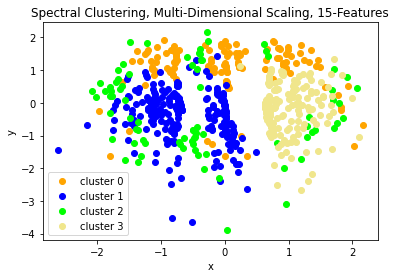

In [222]:
#spectral clustering
#Spectral has no center - so I plot manually instead of using scatterplot function

spec = cluster.SpectralClustering(n_clusters = k).fit(df)
specXYcoordinates = manifold.MDS(n_components=2).fit_transform(df)  #transform to 2D using MDS again

labels = spec.labels_
n_clusters = np.unique(labels).size
for i in range(n_clusters):
    h = plt.scatter(specXYcoordinates[labels==i,0],
                    specXYcoordinates[labels==i,1], 
                    c=colors[i%colors.size],
                    label = 'cluster '+str(i))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Spectral Clustering, Multi-Dimensional Scaling, 15-Features')

Not looking particularly great - lets try and change the manifold technique

In [223]:
tsneSpecXYcoordinates = manifold.TSNE(n_components=2).fit_transform(df) 

for i in range(n_clusters):
    h = plt.scatter(tsneSpecXYcoordinates[labels==i,0],
                    tsneSpecXYcoordinates[labels==i,1], 
                    c=colors[i%colors.size],
                    label = 'cluster '+str(i))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Spectral Clustering, t-SNE, 15-Features')

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Spectral Clustering, t-SNE, 15-Features')

Not great, I think Spectral embedding might work with spectral clustering

In [224]:
specSpecXYcoordinates = manifold.SpectralEmbedding(n_components=2).fit_transform(df) 

for i in range(n_clusters):
    h = plt.scatter(specSpecXYcoordinates[labels==i,0],
                    specSpecXYcoordinates[labels==i,1], 
                    c=colors[i%colors.size],
                    label = 'cluster '+str(i))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Spectral Clustering, Spectral Manifold, 15-Features')

Text(0.5, 1.0, 'Spectral Clustering, Spectral Manifold, 15-Features')

Ok, I hate these graphs, I'm pretty sure it comes down to my cluster size and data set choices. forgive me, but I'm going to try PCA the data and start from the top, I'll do it quickly

### F. Repeat everything on a PCA'd dataset

In [225]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)                     #5 feature from 15 - I worked with 3 above.. 

principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents)

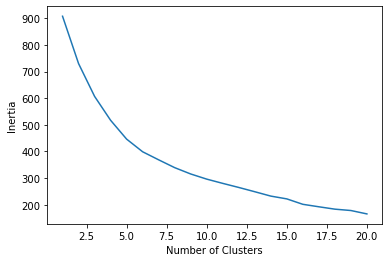

In [226]:
#straight into elbow
PCAError = []

for k in kRange:
    PCAElbow = cluster.KMeans(n_clusters = k, n_init=10, max_iter=300)
    PCAElbow.fit(principalDf)
    PCAError.append(PCAElbow.inertia_)
    
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(kRange, PCAError);

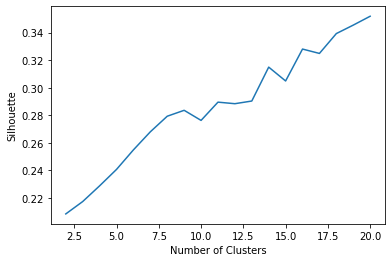

In [227]:
#silhouette PCA
PCASilScore=[]

for k in kSil:
    PCASil = cluster.KMeans(n_clusters = k, n_init=10, max_iter=300)
    PCASil.fit(principalDf)
    PCASilScore.append(silhouette_score(principalDf, PCASil.labels_))
    
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette')
plt.plot(kSil, PCASilScore);

somehow Silhouette is worse... I think k=3 or 4, lets try 3 since 4 wasn't great above.

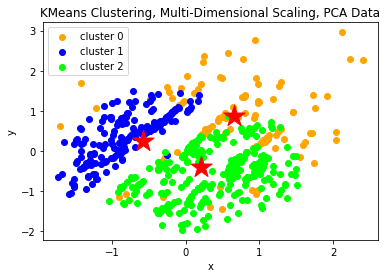

In [228]:
#kmeans
k=3
kMeansPCA = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(principalDf)
kMeansPCACenters = np.r_[principalDf,kMeansPCA.cluster_centers_]                               
kMeansPCAXYcoordinates = manifold.MDS(n_components=2).fit_transform(kMeansPCACenters)  

clustering_scatterplot(points = kMeansPCAXYcoordinates[:-k,:], labels = kMeansPCA.labels_, centers = kMeansPCAXYcoordinates[-k:,:], title='KMeans Clustering, Multi-Dimensional Scaling, PCA Data')

Don't hate this so far... 

Text(0.5, 1.0, 'Spectral Clustering, Multi-Dimensional Scaling, PCA Data')

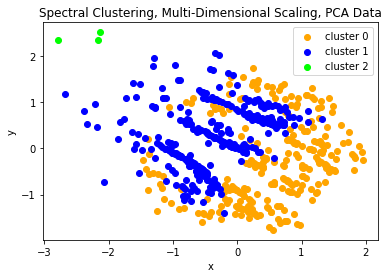

In [229]:
specPCA = cluster.SpectralClustering(n_clusters = k).fit(principalDf)
specPCAXYcoordinates = manifold.MDS(n_components=2).fit_transform(principalDf)  

labelsPCA = specPCA.labels_
n_clusters = np.unique(labelsPCA).size
for i in range(n_clusters):
    h = plt.scatter(specPCAXYcoordinates[labelsPCA==i,0],
                    specPCAXYcoordinates[labelsPCA==i,1], 
                    c=colors[i%colors.size],
                    label = 'cluster '+str(i))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Spectral Clustering, Multi-Dimensional Scaling, PCA Data')

okay, interesting pattern, maybe not bad, I can visualise a conical shape if I think really hard, but I'm going to stick with kmeans and try t-SNE manifold

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


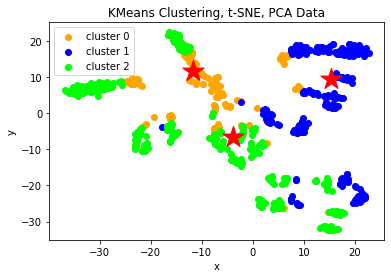

In [230]:
tsnekMeansPCAXYcoordinates = manifold.TSNE(n_components=2).fit_transform(kMeansPCACenters)  

clustering_scatterplot(points = tsnekMeansPCAXYcoordinates[:-k,:], labels = kMeansPCA.labels_, centers = tsnekMeansPCAXYcoordinates[-k:,:], title='KMeans Clustering, t-SNE, PCA Data')

Ok, this did not work very well either. Think I'll take the L today. It'll be interesting to see what others have come up with :)

### G. Cluster Analysis

In [231]:
#kmeans on stripped back datadet (dfNew) - I used this so I can see what the features are
dfNew['cluster'] = pd.Series(kMeans4New.labels_, index=df.index)
dfNew

LoanAmount  ApplicantIncome  Credit_History  Loan_Status_Y  cluster
0      1.058140         1.084523               1              1        2
1      1.047319         0.925883               1              0        1
2      0.635920         0.683858               1              1        2
3      1.002824         0.608992               1              1        2
4      1.115650         1.101869               1              1        2
..          ...              ...             ...            ...      ...
609    0.676143         0.666409               1              1        2
610    0.395858         0.858916               1              1        2
611    1.566110         1.313719               1              1        0
612    1.325676         1.267616               1              1        0
613    1.074155         0.925883               0              0        3

[614 rows x 5 columns]

In [234]:
dfNew.groupby('cluster').mean()

LoanAmount  ApplicantIncome  Credit_History  Loan_Status_Y
cluster                                                            
0          1.515801         1.634726        0.976744       0.895349
1          1.061023         0.856245        1.000000       0.000000
2          0.973215         0.769311        1.000000       1.000000
3          1.060888         0.851326        0.000000       0.068966

So, some interesting trends in the clusters: 

Speaking very relatively:
* Cluster 0: high loan amount, high income, credit history (mostly approved)
* Cluster 1: mid-sized loan, below average income, credit history (Not approved)
* Cluster 2: low loan amount, lower income, credit history (approved)
* Cluster 3: mid-sized loan, below average income, no credit history (Not approved)
    
